## About

This page showcases the work of [Cedric Scherer](https://www.cedricscherer.com), built for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) initiative. You can find the original code on his Github repository [here](https://github.com/z3tt/TidyTuesday/blob/master/R/2020_03_Passwords.Rmd), written in [R](https://www.r-graph-gallery.com).

Thanks to him for accepting sharing his work here! Thanks also to [Tomás Capretto](https://tomicapretto.github.io/) who translated this work from R to Python! 🙏🙏

As a teaser, here is the plot we’re gonna try building:

![preview final chart](https://github.com/holtzy/The-Python-Graph-Gallery/blob/master/static/graph/web-circular-lollipop-plot-with-matplotlib-square.png?raw=true)

## Load libraries

Although today's plot is going to be quite complex, it's only based on Matplotlib, Numpy and Pandas.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load and prepare the data

This guide shows how to create a beautiful multipanel circular lollipop plot to visualize password popularity and strengths.

The data for this post comes from [Information is Beautiful](https://docs.google.com/spreadsheets/d/1cz7TDhm0ebVpySqbTvrHrD3WpxeyE4hLZtifWSnoNTQ/edit#gid=21). This guide uses the dataset released for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) initiative on the week of 2020-01-14. You can find the original announcement and more information about the data [here](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-01-14). Thank you all for making this guide possible!

Let's start by loading and exploring the first rows of the dataset.

In [2]:
df_pw = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-14/passwords.csv')
# Remove rows where the password is missing
df_pw = df_pw.dropna(subset=['password'])
df_pw.head()

,rank,password,category,value,time_unit,offline_crack_sec,rank_alt,strength,font_size
0,1.0,password,password-related,6.91,years,2.170000e+00,1.0,8.0,11.0
1,2.0,123456,simple-alphanumeric,18.52,minutes,1.110000e-05,2.0,4.0,8.0
2,3.0,12345678,simple-alphanumeric,1.29,days,1.110000e-03,3.0,4.0,8.0
3,4.0,1234,simple-alphanumeric,11.11,seconds,1.110000e-07,4.0,4.0,8.0
4,5.0,qwerty,simple-alphanumeric,3.72,days,3.210000e-03,5.0,8.0,11.0


From all the columns in the data frame, only `rank`, `password`, `category`, `value`, and `time_unit` are going to be used. This is what they mean:

- `rank` Popularity in the database of released passwords
- `password` The text of the password
- `category`The category where the password falls into
- `value` Time to crack by online guessing
- `time_unit` Time unit to match with value

The next step is to convert all the time values to a common unit. The following function, `to_seconds()` takes a numeric value and a time unit and converts it to seconds.

In [3]:
def to_seconds(value, time_unit):
    if time_unit == "seconds":
        return value
    elif time_unit == "minutes":
        return value * 60
    elif time_unit == "hours":
        return value * 60 * 60
    elif time_unit == "days":
        return value * 60 * 27
    elif time_unit == "weeks":
        return value * 60 * 24 * 7
    elif time_unit == "months":
        return value * 60 * 24 * 30
    elif time_unit == "years":
        return value * 60 * 24 * 365
    else:
        return np.nan

Let's see some examples

In [4]:
print(to_seconds(152, "seconds"))
print(to_seconds(13.8, "hours"))

152
49680.0


Now let's convert all the times to seconds. The result is a list `TIMES` that contains all the times to crack the password in seconds 

In [5]:
TIMES = [
    to_seconds(row["value"], row["time_unit"])
    for _, row in df_pw.iterrows()
]

And let's define a function that scales the time to the size of the dot in the lollipop.

In [6]:
TIME_MAX = np.max(TIMES)
TIME_MIN = np.min(TIMES)

# 'low' and 'high' refer to the final dot size.
def scale_to_interval(x, low=1, high=60):
    return ((x - TIME_MIN) / (TIME_MAX - TIME_MIN)) * (high - low) + low

## Basic circular plot

In this section we start by defining all the values needed to create the plot. It's the circular nature of the plot that makes us work with quantities such as `ANGLES` and `HEIGHTS`. If you're not too familiar with plots in a circular layout you could have a look at [here](https://python-graph-gallery.com/circular-barplot-basic), [here](https://python-graph-gallery.com/web-radar-chart-with-matplotlib), and [here](https://python-graph-gallery.com/web-circular-barplot-with-matplotlib), which explains more in-depth the basics of circular plots in Matplotlib.

In [7]:
# Different sades of grey used in the plot
GREY88 = "#e0e0e0"
GREY85 = "#d9d9d9"
GREY82 = "#d1d1d1"
GREY79 = "#c9c9c9"
GREY97 = "#f7f7f7"
GREY60 = "#999999"

# Values for the x axis
ANGLES = np.linspace(0, 2 * np.pi, len(TIMES), endpoint=False)

# Heights of the lines and y-position of the dot are given by the times.
HEIGHTS = np.array(TIMES)

# Category values for the colors
CATEGORY_CODES = pd.Categorical(df_pw["category"]).codes

# Colormap taken from https://carto.com/carto-colors/
COLORMAP = ["#5F4690", "#1D6996", "#38A6A5", "#0F8554", "#73AF48", 
            "#EDAD08", "#E17C05", "#CC503E", "#94346E", "#666666"]

# Select colors for each password according to its category.
COLORS = np.array(COLORMAP)[CATEGORY_CODES]


# This is going to be helpful to create some space for labels within the circle 
# Don't worry if it doesn't make much sense yet, you're going to see it in action below
PLUS = 1000

In [8]:
# Create a data frame with the information for the four passwords that are going to be labeled
LABELS_DF = df_pw[df_pw["value"] > 90].reset_index()
# Create labels
LABELS_DF["label"] = [
    f"{pswrd}\nRank: {int(rank)}" 
    for pswrd, rank in zip(LABELS_DF["password"], LABELS_DF["rank"])
]

# Set positions for the labels
LABELS_DF["x"] = [40, 332, 401, 496]
LABELS_DF["y"] = [160000000, 90000000, 45000000, 48498112]

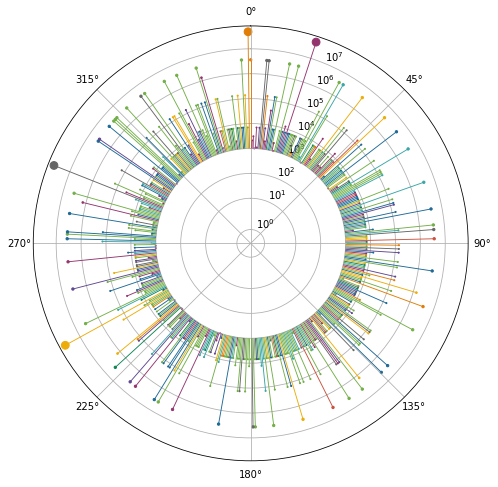

In [9]:
# Initialize layout in polar coordinates
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "polar"})

# Set background color to white, both axis and figure.
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# Use logarithmic scale for the radial axis
ax.set_rscale('symlog')

# Angular axis starts at 90 degrees, not at 0
ax.set_theta_offset(np.pi / 2)

# Reverse the direction to go counter-clockwise.
ax.set_theta_direction(-1)

# Add lines
ax.vlines(ANGLES, 0 + PLUS, HEIGHTS + PLUS, color=COLORS, lw=0.9)

# Add dots
ax.scatter(ANGLES, HEIGHTS + PLUS, s=scale_to_interval(HEIGHTS), color=COLORS);

Do you see that hole in the middle? That's the result of the `PLUS`. Lines go from `y=PLUS` to `y=HEIGHT+PLUS` instead of going from `y=0` to `y=HEIGHT`. It leaves extra space that is going to be used to add some informative
text.

## Clean layout

All the lines and annotations that are added by default aren't very helpful. Let's free our chart from all that clutter and add some minimalistic and better-looking details.

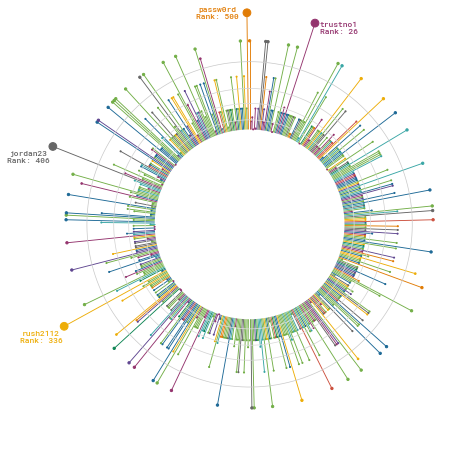

In [10]:
# Start by removing spines for both axes
ax.spines["start"].set_color("none")
ax.spines["polar"].set_color("none")

# Remove grid lines, ticks, and tick labels.
ax.grid(False)
ax.set_xticks([])
ax.set_yticklabels([])

# Add our custom grid lines for the radial axis.
# These lines indicate one day, one week, one month and one year.
HANGLES = np.linspace(0, 2 * np.pi, 200)
ax.plot(HANGLES, np.repeat(1 * 24 * 60 + PLUS, 200), color= GREY88, lw=0.7)
ax.plot(HANGLES, np.repeat(7 * 24 * 60 + PLUS, 200), color= GREY85, lw=0.7)
ax.plot(HANGLES, np.repeat(30 * 24 * 60 + PLUS, 200), color= GREY82, lw=0.7)
ax.plot(HANGLES, np.repeat(365 * 24 * 60 + PLUS, 200), color= GREY79, lw=0.7)

# Add labels for the four selected passwords, which are the most complicated
# passwords to crack.
for idx, row in LABELS_DF.iterrows():
    color = COLORS[row["index"]]
    ax.text(
        x=ANGLES[row["x"]], y=row["y"], s=row["label"], color=color,
        ha="right", va="center", ma="center", size=8,
        family="Roboto Mono", weight="bold"
    )

fig

## Add text annotations

The plot obtained so far looks quite nice, but it's not done. It still lacks something that indicates how to read the story this chart is trying to tell.

This final step consists of adding text annotations which will be very helpful to transmit the story behind this chart. This text is going to be located within the inner circle. Curious about how it works? Let's do it!

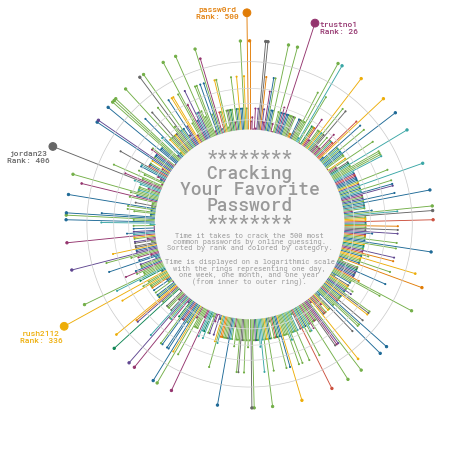

In [11]:
# If you have a look at the beginning of this post, you'll see the inner circle is not white.
# This fill creates the effect of a very light grey background.
ax.fill(HANGLES, np.repeat(PLUS, 200), GREY97)

# Note the 'transform=ax.transAxes'
# It allows us to pass 'x' and 'y' in terms of the (0, 1) coordinates of the axis
# instead of having to use the coordinates of the data.
# (0.5, 0.5) represents the middle of the axis in this transformed coordinate system
ax.text(
    x=0.5, y=0.58, s="********\nCracking\nYour Favorite\nPassword\n********",
    color=GREY60, va="center", ha="center", ma="center", fontfamily="Roboto Mono",
    fontsize=18, fontweight="bold", linespacing=0.87, transform=ax.transAxes
)

ax.text(
    x=0.5, y=0.46, s="Time it takes to crack the 500 most\ncommon passwords by online guessing.\nSorted by rank and colored by category.",
    color=GREY60, va="center", ha="center",  ma="center", fontfamily="Roboto Mono",
    fontsize=7, linespacing=0.87, transform=ax.transAxes
)

ax.text(
    x=0.5, y=0.39, s="Time is displayed on a logarithmic scale\nwith the rings representing one day,\none week, one month, and one year\n(from inner to outer ring).",
    color=GREY60, va="center", ha="center",  ma="center", fontfamily="Roboto Mono",
    fontsize=7, linespacing=0.87, transform=ax.transAxes
)

fig

## Multi panel plot

The original plot we're trying to replicate consists of several panels, and all the work above only replicates the bigger panel on top. The good news is that all the work done is going to be reused in this section where we attempt to replicate the panels in the bottom part of the plot.

Let's start by defining a function that encapsulates all the steps performed above. Changes respect to the original code are explained with comments.

In [12]:
def circular_plot(angles, heights, colors, lw, ax):
    ax.set_facecolor("white")
    
    ax.set_rscale("symlog")
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    ax.spines["start"].set_color("none")
    ax.spines["polar"].set_color("none")
    
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticklabels([])
    
    # The 'lw' argument controls the width of the lines. 
    # This is going to be different for the top and lower panels.
    ax.vlines(angles, 0 + PLUS, heights + PLUS, color=colors, lw=lw)
    ax.scatter(angles, heights + PLUS, s=scale_to_interval(heights), color=colors)
    
    HANGLES = np.linspace(0, 2 * np.pi, 200)
    ax.plot(HANGLES, np.repeat(1 * 24 * 60 + PLUS, 200), color= GREY88, lw=0.7)
    ax.plot(HANGLES, np.repeat(7 * 24 * 60 + PLUS, 200), color= GREY85, lw=0.7)
    ax.plot(HANGLES, np.repeat(30 * 24 * 60 + PLUS, 200), color= GREY82, lw=0.7)
    ax.plot(HANGLES, np.repeat(365 * 24 * 60 + PLUS, 200), color= GREY79, lw=0.7)
    
    ax.fill(HANGLES, np.repeat(PLUS, 200), GREY97)
    
    # Change upper limit of the radial axis so larger dots fit within the plot area
    ax.set_rmax(ax.get_rmax() * 2)

There's also this little helper function which add line breaks to some existing category names so they fit within the inner circle.

In [13]:
def map_category(category):
    if category == "cool-macho":
        return "cool-\nmacho"
    elif category == "nerdy-pop":
        return "nerdy-\npop"
    elif category == "password-related":
        return "password-\nrelated"
    elif category == "rebellious-rude":
        return "rebel-\nlious-\nrude"
    elif category == "simple-alphanumeric":
        return "simple-\nalpha-\nnumeric"
    else:
        return category

And these two new lists that will be used when iterating through categories of passwords.

In [14]:
CATEGORIES = sorted(pd.Categorical(df_pw["category"]).unique())
LABELS = [map_category(category) for category in CATEGORIES]

Let's make the plot!

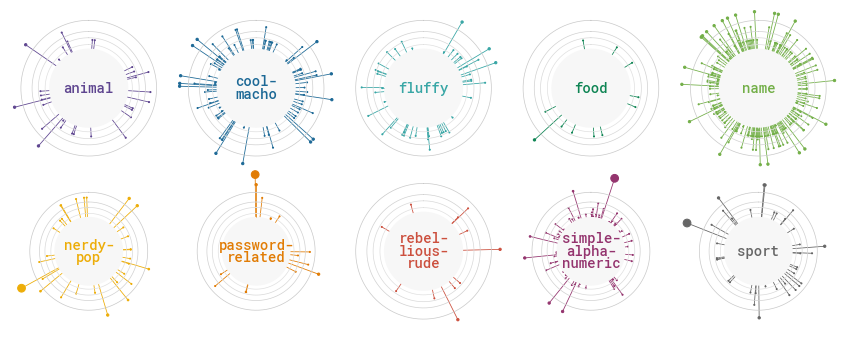

In [15]:
# The plot consists of 2 rows and 5 columns (10 categories in total)
fig, axes = plt.subplots(2, 5, figsize=(15, 6), subplot_kw={"projection": "polar"})
fig.patch.set_facecolor("white")

# Define the slices used to iterate through 'axes'.
# It iterates in a rowwise manner.
# It starts in the first row, and iterates over all the columns of that row
# from left to right, then it goes to the next row and does the same.
SLICES = [(i, j) for i in range(2) for j in range(5)]

for category, label, slice_ in zip(CATEGORIES, LABELS, SLICES):
    # Select axis
    ax = axes[slice_]
    
    # Select indexes corresponding to the passwords in this category
    idx = df_pw.index[df_pw["category"] == category].tolist()
    
    # Subset ANGLES, HEIGHTS, and COLORS to use the ones for this category.
    angles = ANGLES[idx]
    heights = HEIGHTS[idx]
    colors = COLORS[idx]
    
    # Create circular plot
    circular_plot(angles, heights, colors, 0.8, ax)
    
    # Add text within the inner circle representing the category
    ax.text(
        x=0.5, y=0.5, s=label, color=colors[0], va="center", ha="center",
        ma="center", fontfamily="Roboto Mono", fontsize=14, fontweight="bold",
        linespacing=0.87, transform=ax.transAxes
    )

# Adjust space between subplots.
# 'wspace=0' leaves no horizontal space between subplots.
# 'hspace=0' leaves no vertical space between subplots.
fig.subplots_adjust(wspace=0, hspace=0)

## Create layout for the final chart

The layout of the final chart is rather complex because it's not just a plot made of equal panels given by `n` rows and `m` columns. In this case, the plot is made of a large panel on top and ten smaller panels distributed a (2, 5) grid below. 

Our strategy relies on Matplotlib's [`GridSpec`](https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html). The first step is to initialize a figure with a layout that consists of 30 subplots distributed in 6 rows and 5 columns. Then, all the subplots corresponding to the four rows on top are combined to create a unique subplot that will contain the larger radar chart. The 10 subplots on the bottom are left for the plots corresponding to the categories.

Does it sound like a very complicated thing to do? Don't be afraid! It's not that hard. Just have a look at the next chunk of code:

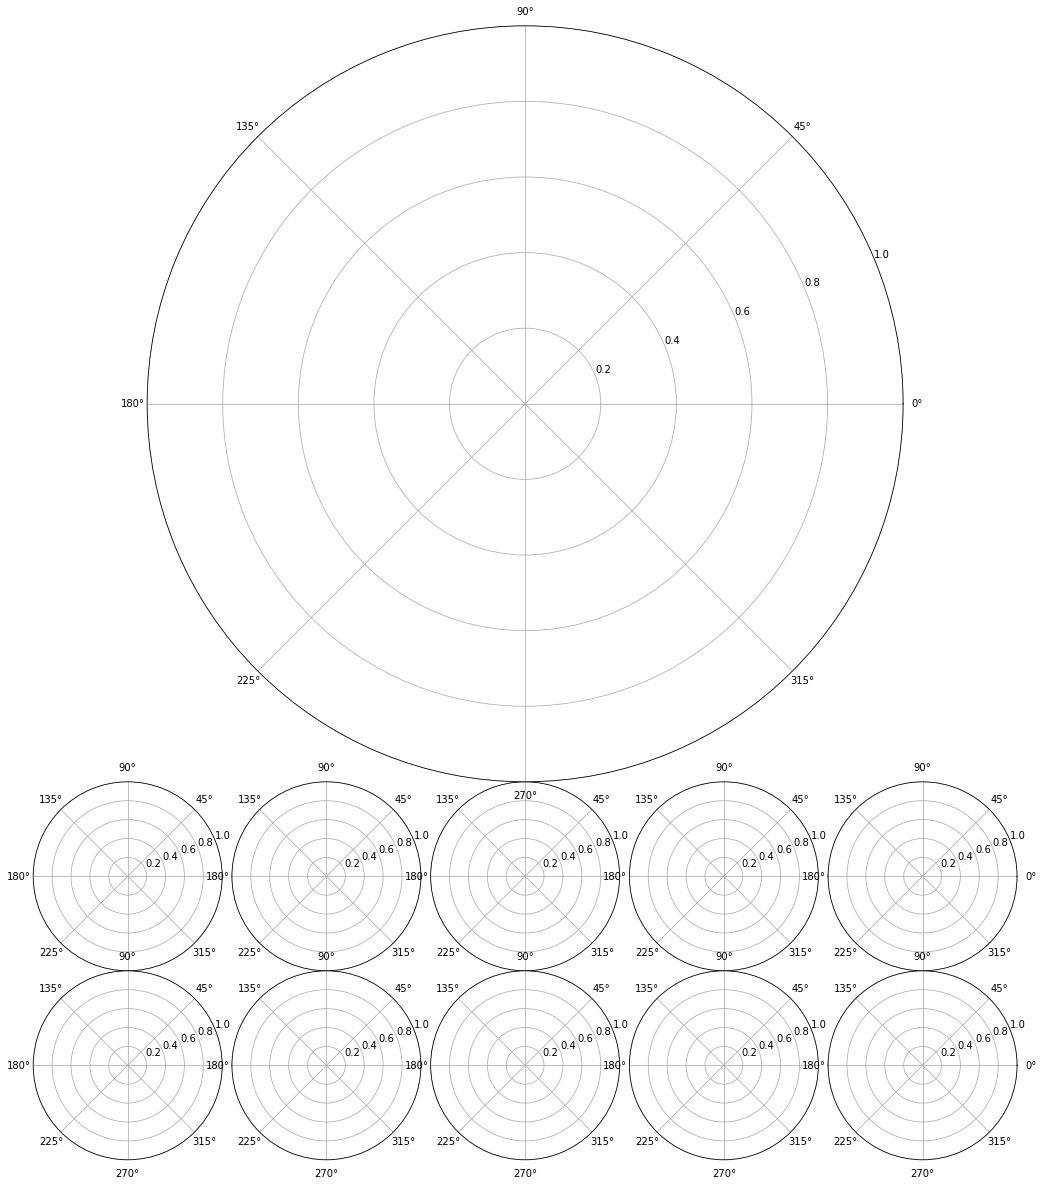

In [16]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15, 17.5), subplot_kw={"projection": "polar"})
fig.patch.set_facecolor("white")
gs = axes[0, 0].get_gridspec()

# Remove the underlying axes for the subplots that are going to be combined
for i in range(4):
    for j in range(5):
        axes[i, j].remove()

# Combine subplots into one larger subplot
ax_big = fig.add_subplot(
    gs[:4, :], # takes all the subplots on the first 4 rows.
    projection="polar" # indicates this big axis uses a polar projection
)

# Set its aspect to "equal" so it is centered
ax_big.set_aspect("equal")

# Adjust margin and space between subplots
fig.subplots_adjust(
    left=0.04, bottom=0.05, right=0.96, top=0.95, # margins
    wspace=0, hspace=0 # spaces
)

## Final chart

Now that the layout is specified, it's time to incorporate all the plots we've been building above into this new layout. Let's start by the larger one.

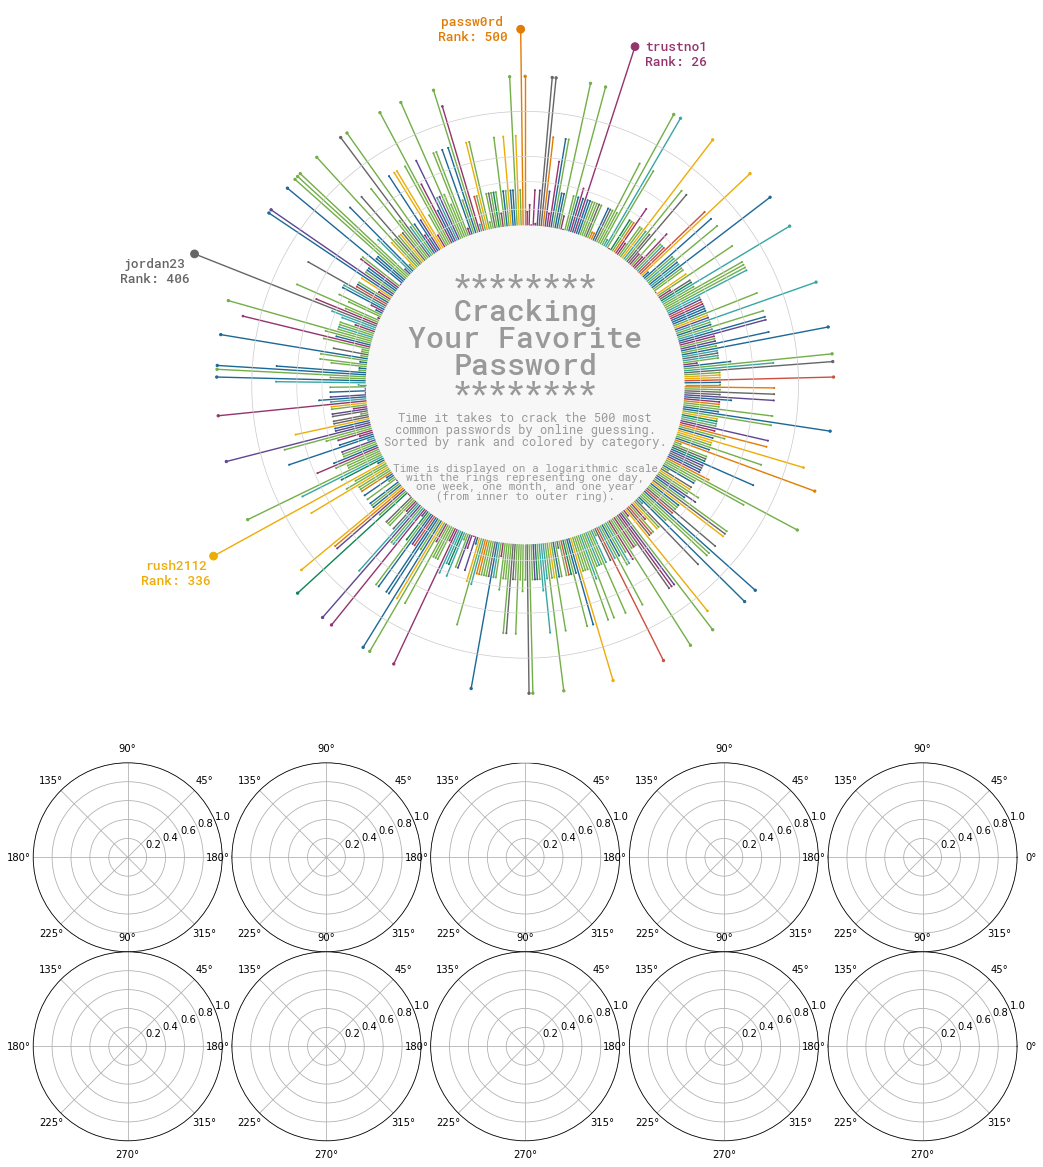

In [17]:
# Add circular plot
circular_plot(ANGLES, HEIGHTS, COLORS, 1.4, ax_big)

# Add text annotations
for idx, row in LABELS_DF.iterrows():
    color=COLORS[row["index"]]
    ax_big.text(
        ANGLES[row["x"]], row["y"], row["label"], ha="right", va="center",
        ma="center", size=13, family="Roboto Mono", weight="bold", color=color
    )

ax_big.text(
    x=0.5, y=0.56, s="********\nCracking\nYour Favorite\nPassword\n********",
    color=GREY60, va="center", ha="center", ma="center", fontfamily="Roboto Mono",
    fontsize=30, fontweight="bold", linespacing=0.95, transform=ax_big.transAxes
)

ax_big.text(
    x=0.5, y=0.44, s="Time it takes to crack the 500 most\ncommon passwords by online guessing.\nSorted by rank and colored by category.",
    color=GREY60, va="center", ha="center", ma="center", fontfamily="Roboto Mono",
    fontsize=12, linespacing=0.87, transform=ax_big.transAxes
)

ax_big.text(
    x=0.5, y=0.37, s="Time is displayed on a logarithmic scale\nwith the rings representing one day,\none week, one month, and one year\n(from inner to outer ring).",
    color=GREY60, va="center", ha="center", ma="center", fontfamily="Roboto Mono",
    fontsize=11, linespacing=0.87, transform=ax_big.transAxes
)
fig

And finally, let's add the charts for the subplots on the bottom:

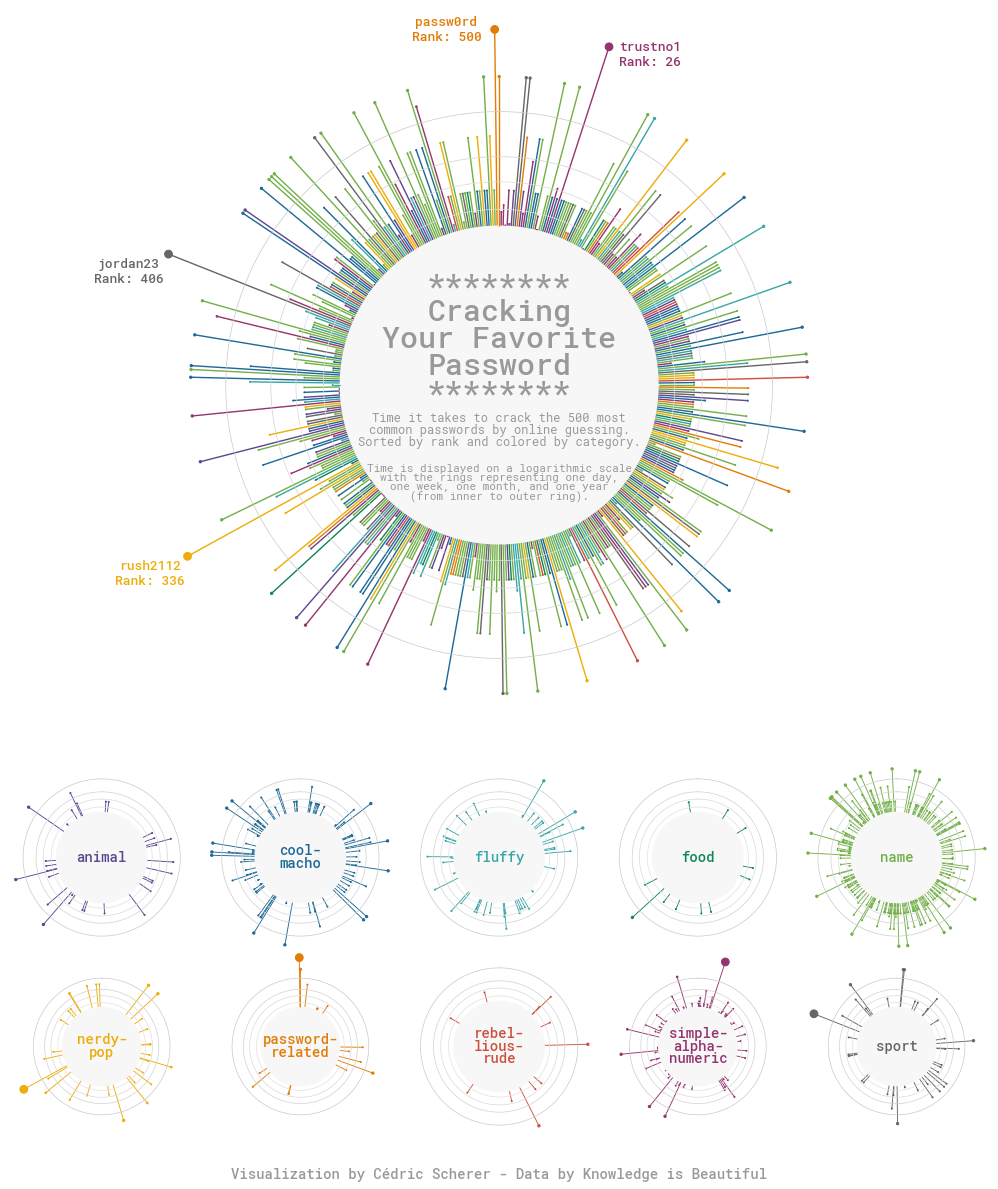

In [18]:
# Note these have changed because we iterate on rows 
# 4 and 5 (fifth and sixth, respectively)
slices = [(i + 4, j) for i in range(2) for j in range(5)]

for category, label, idx_ax in zip(CATEGORIES, LABELS, slices):
    ax = axes[idx_ax]
    idx = df_pw.index[df_pw["category"] == category].tolist()
    
    angles = ANGLES[idx]
    heights = HEIGHTS[idx]
    colors = COLORS[idx]
    
    circular_plot(angles, heights, colors, 0.9, ax)
    
    ax.text(
        x=0.5, y=0.5, s=label, color=colors[0], va="center", ha="center",
        ma="center", fontfamily="Roboto Mono", fontsize=14, fontweight="bold",
        linespacing=0.87, transform=ax.transAxes
    )

fig.text(
    x=0.5, y=0.02, s="Visualization by Cédric Scherer - Data by Knowledge is Beautiful",
    color=GREY60, fontsize=14, ha="center", fontfamily="Roboto Mono", fontweight="bold"
)

# Do something like fig.savefig("plot.png", dpi=300) to have it in better quality.
fig

Awesome, we nailed it!!🥳